# Titanic Dataset

## 1) Data Understanding

### 1a) Read in Titanic Data & Train/Test Split

In [21]:
##Read in Packages
import os
import urllib.request
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display_html
from itertools import chain,cycle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold

In [24]:
TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data() 

In [25]:
def load_titanic_data(filename, titanic_path = TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [26]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

### 1b) Find missing data & general statistics

#### Age/Embarked/Cabin contain missing features

In [5]:
print(train_data.info(), test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [6]:
train_data.head(50)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


###### - Age - 75% below age 38yr; Max 80yr 
###### - Parch -  24% have parents or children
###### - SibSp -   32% have Siblings or Spouse
###### - Fare - Varies significantly from $7-512

In [7]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
# Find percentage with Siblings/Spouse or Parent/Child
SibSp, Parch = train_data['SibSp'], train_data['Parch']
hasSibSp, hasParch = SibSp[SibSp > 0].count(), Parch[Parch > 0].count()
print('Percent Sibling/Spouse:', hasSibSp/891, '/ Percent has Parents or Children:', hasParch/891)

Percent Sibling/Spouse: 0.3176206509539843 / Percent has Parents or Children: 0.23905723905723905


### 1c) Pivot Features

In [9]:
# create multiple tables side by side
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

###### - 75% females VS 18% Males Survived
###### - Class is predictive of Survival
###### - SibSp/Parch do not show trend between size and Survival
###### - Embarked is predictive of Survival

In [10]:
#Categorical Variables VS Survived
SexSurvived = train_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()
ClassSurvived = train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()
SibSpSurvived = train_data[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean()
ParchSurvived = train_data[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean()
EmbarkedSurvived = train_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()
display_side_by_side(SexSurvived, ClassSurvived, SibSpSurvived, ParchSurvived, EmbarkedSurvived,
                     titles=['SexSurvived', 'ClassSurvived', 'SibSpSurvived', 'ParchSurvived', 'EmbarkedSurvived'])

,Sex,Survived
0,female,0.742038
1,male,0.188908
,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363
,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286


#### - Age correlated with Class and Sex
#### - 1st class has oldest
#### - Males older than women by sex and class

In [12]:
# find Correlation between Class/Sex and Age
ClassAge = train_data[['Pclass', 'Age']].groupby(['Pclass'], as_index=False).mean()
SexAge = train_data[['Sex', 'Age']].groupby(['Sex'], as_index=False).mean()
SexClassAge = train_data[['Sex', 'Pclass', 'Age']].groupby(['Sex', 'Pclass'], as_index=False).mean()
display_side_by_side(ClassAge, SexAge, SexClassAge, titles=['ClassAge', 'SexAge', 'SexClassAge'])

ClassAge 
 
 
 
 Pclass 
 Age 
 
 
 
 
 0 
 1 
 38.233423 
 
 
 1 
 2 
 29.877649 
 
 
 2 
 3 
 25.140610 
 
 
 SexAge 
 
 
 
 Sex 
 Age 
 
 
 
 
 0 
 female 
 27.915709 
 
 
 1 
 male 
 30.726637 
 
 
 SexClassAge 
 
 
 
 Sex 
 Pclass 
 Age 
 
 
 
 
 0 
 female 
 1 
 34.611765 
 
 
 1 
 female 
 2 
 28.722973 
 
 
 2 
 female 
 3 
 21.750000 
 
 
 3 
 male 
 1 
 41.281353 
 
 
 4 
 male 
 2 
 30.740740 
 
 
 5 
 male 
 3 
 26.507576

### 1d) Visualize Data

#### - greatest correlation between Class and Fare
#### - negative correlation between SibSp and Age, and Parch and Age
#### - positive correlation between SibSp and Parch

<AxesSubplot:>

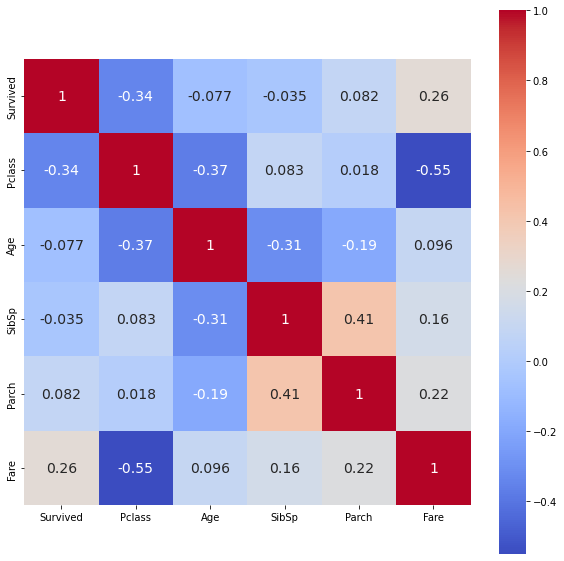

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train_data.drop(['PassengerId'], axis=1).corr(), ax=ax,  annot=True, 
            square=True, cmap='coolwarm', annot_kws={'size': 14})


#### Older individuals faired better than younger 

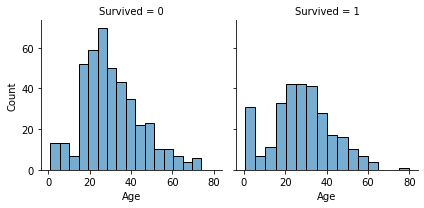

In [14]:
#Age vs Survival
AgeSurvival = sns.FacetGrid(train_data, col='Survived')
AgeSurvival.map(sns.histplot,  'Age', alpha=.6)


##### Older individuals in first and second class faired better than young individuals in third class. First class skews old while third class skews young.

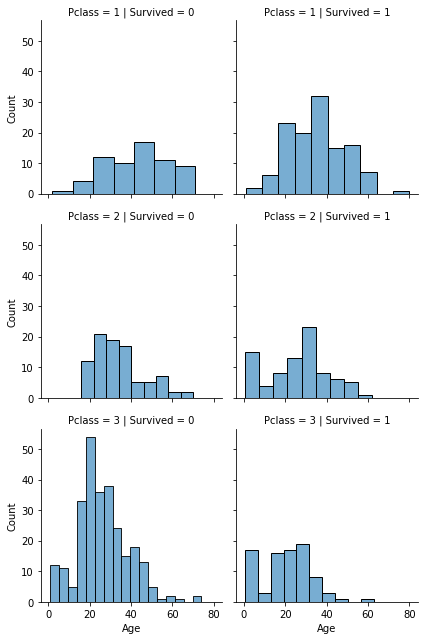

In [15]:
#Age/Class vs Survival

AgeClassSurvival = sns.FacetGrid(train_data, col='Survived', row='Pclass')
AgeClassSurvival.map(sns.histplot, 'Age', alpha=.6)

##### - Embarked Q has lowest survival rates for men regardless of class
##### - First and Second class men had higher survival rate when embarked at C
##### - Females had lowest survival rate when embarkd at C 

C:\Users\CadeA\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\CadeA\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\CadeA\anaconda3\lib\site-packages\seaborn\axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


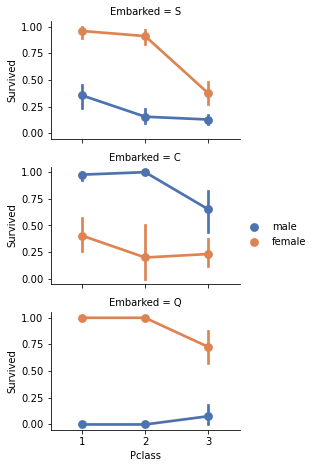

In [16]:
# Embarked vs Survival
EmbarkedSurvived = sns.FacetGrid(train_data, row='Embarked', size=2.2, aspect=1.6)
EmbarkedSurvived.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
EmbarkedSurvived.add_legend()

#### Higher paying passengers had better survival rates
#### Embarked C and S had higher fare prices

C:\Users\CadeA\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\CadeA\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


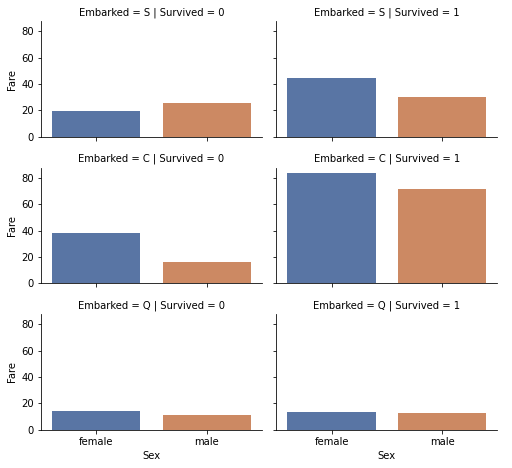

In [17]:
#Embarked/Fare vs Survival
EmbarkedFare = sns.FacetGrid(train_data, row='Embarked', col='Survived', size=2.2, aspect=1.6)
EmbarkedFare.map(sns.barplot, 'Sex', 'Fare', alpha=1, ci=None, palette='deep')
EmbarkedFare.add_legend()

## 2 Data Processing

### 2a) fill in Age/Embarked/Fare values

#### Guess Age by grouping Pclass and Sex
#### Guess Embarked and Fare by most frequent

In [18]:
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.age_means_ = {}
        self.port_guess= None

    def fit(self, X, y=None):
        self.age_means_ = X.groupby(['Pclass', 'Sex']).Age.mean()
        self.port_guess = X.Embarked.dropna().mode()[0]
        self.fare_guess = X.Fare.dropna().mode()[0]

        return self

    def transform(self, X, y=None):
        # fill Age
        for key, value in self.age_means_.items():
            X.loc[((np.isnan(X["Age"])) & (X.Pclass == key[0]) & (X.Sex == key[1])), 'Age'] = value
        # fill embarked
        X['Embarked'] = X.Embarked.fillna(self.port_guess)
        X['Fare'] = X.Fare.fillna(self.fare_guess)
        return X

### 2b) Feature Engineering

#### Extract title from name and group by most common
#### Create familysize attrib then condense to IsAlone

In [19]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # simplify title names
        title_extract = X.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
        X['Title'] = title_extract.replace('Mlle', 'Miss').replace('Ms', 'Miss').replace('Mme', 'Mrs').replace(['Lady', 
                                'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major',
                                 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        X = X.drop('Name', axis =1)
        
        # create family size/ IsAlone
        X['FamilySize'] = X.Parch + X.SibSp
        X['IsAlone'] = 0
        X.loc[X['FamilySize'] ==1, 'IsAlone'] = 1
        X = X.drop(['FamilySize', 'SibSp', 'Parch'],  axis=1)
        
        # create Age*Pclass
        X['Age*Pclass'] = X.Age * X.Pclass
        
        return X

## 3) Data Preparation

### 3a) Create initial pipeline using custom classes

In [27]:
from sklearn.pipeline import Pipeline
y_train = train_data['Survived']
train_data = train_data.drop(['Survived'], axis=1)

initial_pipeline = Pipeline([
    ('CustomImputer', CustomImputer()),
    ('FeatureExtractor', FeatureExtractor())
])

fixed_train_data = initial_pipeline.fit_transform(train_data)


### 3b) Encode and scale features

In [28]:
num_attribs = ['Age', 'Fare', 'Age*Pclass' ]
cat_attribs = ['Sex', 'Pclass', 'Embarked', 'IsAlone', 'Title']

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("cat_encoder", OneHotEncoder(sparse=False))
])
preprocess_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

X_train = preprocess_pipeline.fit_transform(fixed_train_data)


In [30]:
X_train = pd.DataFrame(X_train, columns=['Age', 'Fare', 'Age*Pclass', 'Male', 'Female', 'Pclass1', 'Pclass2', 'Pclass3', 'EmbarkedS', 
                               'EmbarkedC', 'EmbarkedQ', 'Alone', 'NotAlone', 'Mr', 'Miss', 'Mrs', 'Master', 'Rare'])
X_train = X_train.drop(['Female', 'NotAlone'], axis=1)


## 4) Modeling

### 4a) Model Selection

In [31]:
param_grid = {
    "n_estimators":[25, 50, 100, 150], 
    'criterion':['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    "max_depth":[3, 5, 7, 9, 11, 13],
}

forest_class = RandomForestClassifier()

In [32]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(forest_class, param_grid, cv = cv,
return_train_score=True, scoring='f1')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 9, 11, 13],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [25, 50, 100, 150]},
             return_train_score=True, scoring='f1')

In [33]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 50}

In [75]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [76]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [77]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': False}

### 4b) Train Model and Evaluate

In [83]:
forest_model = RandomForestClassifier(n_estimators=2000, min_samples_split=10,
                                      min_samples_leaf=4, max_features='auto', max_depth=100, bootstrap=False)

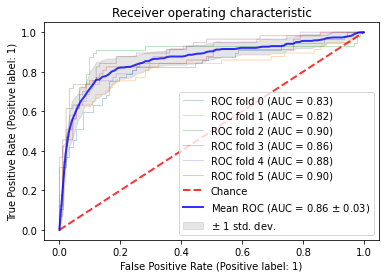

In [84]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

X = X_train.to_numpy()
y = y_train.to_numpy()



# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = RandomForestClassifier( n_estimators=2000, min_samples_split=10,
                                      min_samples_leaf=4, max_features='auto', max_depth=100, bootstrap=False)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic",
)
ax.legend(loc="lower right")
plt.show()

##### Cross validation ROC indicates model generalizes well to unseen data. Average AUC (0.86) is a significant improvement upon a pure chance model; however, results are less significant given a model that only predicts fatalities which would be 68% accurate.

In [85]:
forest_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=100, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=2000)

In [86]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_model, X_train, y_train, cv =10)
forest_scores.mean()

0.8316978776529338

##### Figure below shows model accuracy. Accuracy appears to vary significantly and may indicate the model is over fitted

{'whiskers': [<matplotlib.lines.Line2D at 0x183e65aa1f0>,
 'caps': [<matplotlib.lines.Line2D at 0x183e65aa490>,
 'boxes': [<matplotlib.lines.Line2D at 0x183e66b3e80>],
 'medians': [<matplotlib.lines.Line2D at 0x183e65a5d60>],
 'fliers': [<matplotlib.lines.Line2D at 0x183e65a5820>],
 'means': []}

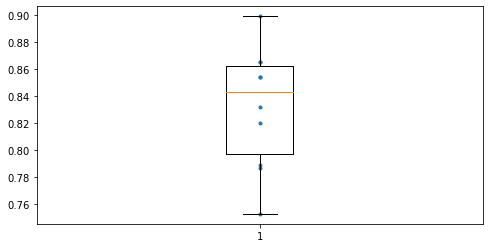

In [87]:
plt.figure(figsize=(8,4))
plt.plot([1]*10, forest_scores, ".")
plt.boxplot(forest_scores)


In [88]:
for feature in zip(X_train.columns, forest_model.feature_importances_):
    print(feature)

('Age', 0.07469574530741452)
('Fare', 0.1392163701345004)
('Age*Pclass', 0.1282814473262415)
('Male', 0.17604461906906266)
('Pclass1', 0.03064406119627584)
('Pclass2', 0.02228433887022894)
('Pclass3', 0.07270746826533205)
('EmbarkedS', 0.008568284906508487)
('EmbarkedC', 0.008043412585563438)
('EmbarkedQ', 0.013553353905536174)
('Alone', 0.006250866231341096)
('Mr', 0.008688678761423704)
('Miss', 0.04637287844413744)
('Mrs', 0.1952997429170871)
('Master', 0.05970817795820399)
('Rare', 0.009640554121142626)


#### Sex, Mrs, Age*Pclass, Fare, and Age are most impactful features. Large standard deviation amongs features which may warrant a second look

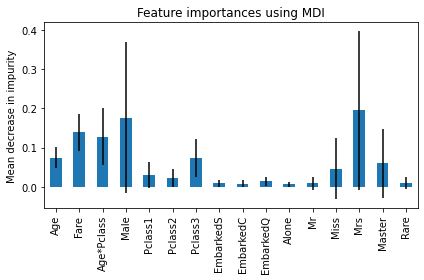

In [89]:
importances = forest_model.feature_importances_
forest_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_model.estimators_], axis=0)
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 5) Predict and Exports Results

In [90]:
fixed_test_data = initial_pipeline.transform(test_data)
X_test = preprocess_pipeline.transform(fixed_test_data)
X_test = pd.DataFrame(X_test, columns=['Age', 'Fare', 'Age*Pclass', 'Male', 'Female', 'Pclass1', 'Pclass2', 'Pclass3', 'EmbarkedS', 
                               'EmbarkedC', 'EmbarkedQ', 'Alone', 'NotAlone', 'Mr', 'Miss', 'Mrs', 'Master', 'Rare'])
X_test = X_test.drop(['Female', 'NotAlone'], axis=1)

In [91]:

y_pred = forest_model.predict(X_test)
prediction = pd.DataFrame({"PassengerId":test_data['PassengerId'], 'Survived':y_pred}).to_csv('predictions.csv')